2025-10-28 10:43:24.613 | INFO     | __main__:<module>:40 - Merged dataset has 4565 messages from 78 authors.
2025-10-28 10:43:24.616 | INFO     | __main__:<module>:52 - Aggregated emoji counts per floor:
2025-10-28 10:43:24.618 | INFO     | __main__:<module>:53 - 
   Floor_nr  emoji_count
0         1           48
1         2           24
2         3          112
3         4           48
4         5          180
5         6          197
6         7           74
7         8          154
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_57997/434001652.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


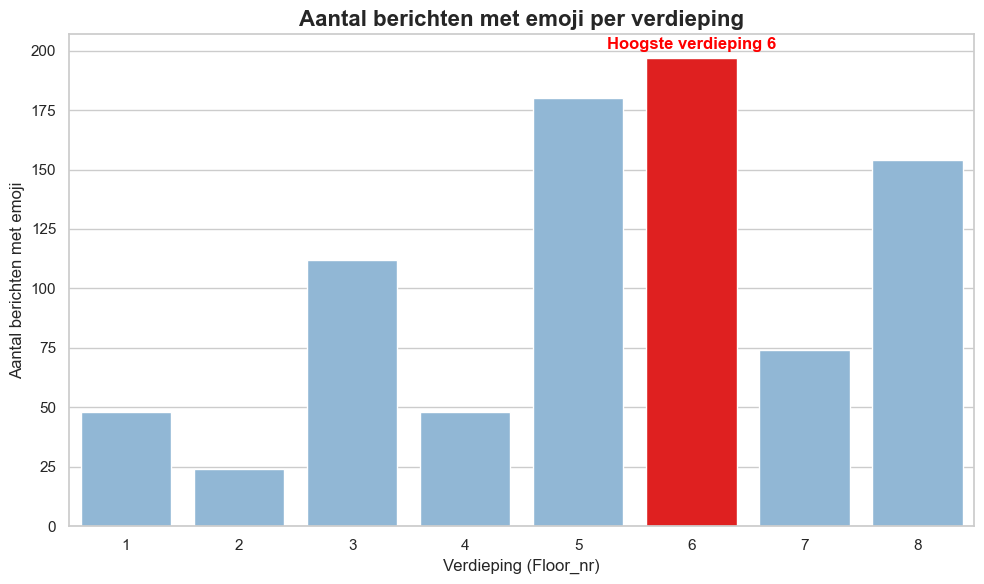

In [ ]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path
import tomllib
from loguru import logger

# --- Configuration ---
sns.set_theme(style="whitegrid", palette="muted")

# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. Run src/preprocess.py first and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# --- Load metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={"index": "author"})
)

# --- Merge WhatsApp data with user info ---
df_merged = df.merge(author_info_df, on="author", how="left")

logger.info(f"Merged dataset has {len(df_merged)} messages from {df_merged['author'].nunique()} authors.")

# --- Prepare data for analysis ---
# Group by floor and count messages that contain emojis
emoji_by_floor = (
    df_merged.groupby("Floor_nr")["has_emoji"]
    .sum()  # counts True values (emoji messages)
    .reset_index()
    .rename(columns={"has_emoji": "emoji_count"})
    .sort_values("Floor_nr")
)

logger.info("Aggregated emoji counts per floor:")
logger.info(f"\n{emoji_by_floor}")

# --- Plot with highest bar in red ---
plt.figure(figsize=(10, 6))

# Find the floor with the highest emoji count
max_floor = emoji_by_floor.loc[emoji_by_floor["emoji_count"].idxmax(), "Floor_nr"]

# Create colors: red for max, muted blue for others
colors = ["red" if floor == max_floor else "#86b9e0" for floor in emoji_by_floor["Floor_nr"]]

sns.barplot(
    data=emoji_by_floor,
    x="Floor_nr",
    y="emoji_count",
    palette=colors
)

plt.title("Aantal berichten met emoji per verdieping", fontsize=16, fontweight="bold")
plt.xlabel("Verdieping", fontsize=12)
plt.ylabel("Aantal berichten met emoji", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Annotate the highest bar for clarity
max_value = emoji_by_floor["emoji_count"].max()
plt.text(
    x=emoji_by_floor.index[emoji_by_floor["Floor_nr"] == max_floor][0],
    y=max_value + (max_value * 0.02),
    s=f"Hoogste verdieping {max_floor}",
    ha="center",
    color="red",
    fontweight="bold"
)

plt.show()


# # --- Plot ---
# plt.figure(figsize=(10, 6))
# sns.barplot(
#     data=emoji_by_floor,
#     x="Floor_nr",
#     y="emoji_count",
#     palette="crest"
# )

# plt.title("Aantal berichten met emoji per verdieping", fontsize=16, fontweight="bold")
# plt.xlabel("Verdieping (Floor_nr)", fontsize=12)
# plt.ylabel("Aantal berichten met emoji", fontsize=12)
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()

# # --- Save plot ---
# img_dir = Path.cwd() / "img"
# img_dir.mkdir(parents=True, exist_ok=True)
# save_path = img_dir / "emoji_usage_by_floor.png"

# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# plt.close()

# logger.info(f"Plot saved successfully to {save_path}")
# print(f"✅ Plot saved to: {save_path}")
